<p style="text-align: center; font-size: 300%"> ARCH Models in Julia </p>
<p style="text-align: center; font-size: 200%"> Simon A. Broda </p>
<p style="text-align: center; font-size: 100%"> University of Zurich and University of Amsterdam <br>
<a href="mailto:simon.broda@uzh.ch">simon.broda@uzh.ch</a> </p>
<img src="LOGO_ERC-FLAG_EU_.jpg" alt="LOGO" style="display:block; margin-left: auto; margin-right: auto; width: 20%;">
<p style="text-align: center; font-size: 100%"> This project has received funding from the European Research Council (ERC) under the European Union's Horizon 2020 research and innovation program (grant agreement No. 750559). </p>

# Introduction
* Daily financial returns data exhibit a number of *stylized facts*:
  * Volatility clustering
  * Non-Gaussianity, fat tails
  * Leverage effects: negative returns increase future volatility
* These effects are important in many areas in finance, in particular in risk management.
* [G]ARCH ([**G**eneralized] **A**utoregressive **C**onditional **V**olatility) models are the most popoular for modelling them.

In [1]:
using MarketData, TimeSeries, Plots, Distributions, KernelDensity, StatPlots
pyplot()
r = percentchange(MarketData.AAPL["Adj. Close"])
p = plot(r)
savefig("returns")

## Example: volatility clustering in AAPL returns
<img src="returns.png" alt="RETURNS" style="display:block; margin-left: auto; margin-right: auto; width: 50%;">

In [2]:
plot(kde(r.values), label="Kernel Density")
plot!(fit(Normal,r.values), label="Fitted Normal")
savefig("kde")

## Example: fat tails in AAPL return density
<img src="kde.png" alt="Kernel Density" style="display:block; margin-left: auto; margin-right: auto; width: 50%;">



# (G)ARCH Models
  * Basic setup: given a sample of financial returns $\{r_t\}_{t\in\{1,\ldots,T\}}$, decompose $r_t$ as
  $$
  r_t=\mu_t+\sigma_tz_t, \quad z_t\stackrel{i.i.d.}{\sim}(0,1).
  $$
  * Focus is on the *volatility* $\sigma_t$. G(ARCH) models make $\sigma_t$ a function of *past* returns and variances.
  



# The ARCH Package
* design
* 0.6 only so far
* install (in 0.6) via
* Repo at https://github.com/s-broda/ARCH.jl


# Benchmarks
  * Bollerslev and Ghysels (JBES 1996) data is de facto standard in comparing implementations of GARCH models.
  * Data consist of daily German mark/British pound exchange rates (1974 observations).

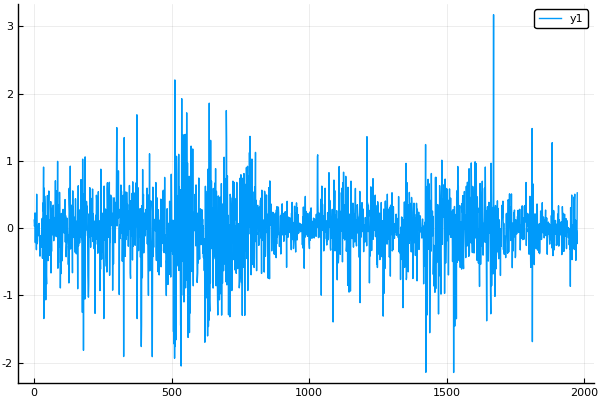

In [3]:
using HTTP
isfile("DMGBP.txt") && open("DMGBP.txt", "w") do io
    HTTP.get("http://people.stern.nyu.edu/wgreene/Text/Edition7/TableF20-1.txt", response_stream=io)
end
r = convert.(Float64, readcsv("DMGBP.txt")[2:end]);
plot(r)

* Fitting in Julia:

In [9]:
using ARCH, BenchmarkTools
@btime fit(GARCH{1, 1}, $r, meanspec=NoIntercept) #Matlab doesn't use an intercept


GARCH{1,1} model with Gaussian errors, T=1974.


Volatility parameters:

      Estimate  Std.Error z value Pr(>|z|)
ω    0.0110992 0.00665741 1.66719   0.0955
β₁    0.804287  0.0744193 10.8075   <1e-26
α₁    0.149875  0.0543414 2.75803   0.0058



  9.647 ms (2338 allocations: 113.64 KiB)


* Now Matlab:

In [ ]:
using MATLAB

In [7]:
#run this cell a few times to give Matlab a fair chance
mat"tic; estimate(garch(1, 1), $r); toc; 0";

 
    GARCH(1,1) Conditional Variance Model (Gaussian Distribution):
 
                 Value      StandardError    TStatistic      PValue  
                ________    _____________    __________    __________

    Constant    0.010868      0.0012972        8.3779      5.3896e-17
    GARCH{1}     0.80452       0.016038        50.162               0
    ARCH{1}      0.15433       0.013852        11.141      7.9448e-29

Elapsed time is 0.079333 seconds.


* ARCH.jl is faster by about a factor 6.
* Estimates are quite similar, but the standard errors and $t$-statistics are not.
* So which is correct? Let's compare with the results from Brooks et. al. (Int. J. Fcst. 2001).
* They use a model with intercept, so let’s re-estimate in Julia (not sure how to include an intercept in Matlab):

In [10]:
@btime fit(GARCH{1, 1}, $r)


GARCH{1,1} model with Gaussian errors, T=1974.


Mean equation parameters:

        Estimate  Std.Error   z value Pr(>|z|)
μ    -0.00626931 0.00923712 -0.678709   0.4973

Volatility parameters:

      Estimate  Std.Error z value Pr(>|z|)
ω    0.0109834 0.00657626 1.67016   0.0949
β₁    0.805808   0.073853  10.911   <1e-26
α₁      0.1487  0.0540332   2.752   0.0059



  13.024 ms (2785 allocations: 146.84 KiB)


* Brooks et. al. give the estimates (**$t$-stats**)
$\mu=−0.00619$ $(\mathbf{−0.67})$, $\omega=0.0108$ $(\mathbf{1.66})$, $\beta_1=0.806$ $(\mathbf{11.11})$, $\alpha_1=0.153$ $(\mathbf{2.86})$.
* We are pretty close. Difference is due to the way presample values are computed. We can match Brooks et. al. exactly if we use the historical instead of the unconditional variance instead.

#  TODO
*  0.7 compatibility
*  docs
*  forecasting
*  More models, distributions
*  Value at Risk
*  backtesting


# References
* Bollerslev, T. & Ghysels, E. (1996). Periodic Autoregressive Conditional Heteroscedasticity. *Journal of Business & Economic Statistics* **14**, 139-151. https://doi.org/10.1080/07350015.1996.10524640
* Brooks, C., Burke, S. P., & Persand, G. (2001). Benchmarks and the accuracy of GARCH model estimation. *International Journal of Forecasting* **17**, 45-56. https://doi.org/10.1016/S0169-2070(00)00070-4.
